# Bait n' Switch

### Clickbait classification and removal

### Business problem

I have assumed the role of a data scientist working at a software company that wants to make improvements on their web browser deliverable. Market analysis has revealed that users are frustrated with the rise in clickbait and feel like the credibility of journalism has greatly diminished. The stakeholders want to offer our users the option to filter out or flag clickbait headlines from their browsing experience in order to set their browser apart from the others.


### Context

The online journalism economy is driven by pay per click (PPC) advertising. Pay per click is an advertisement payment structure where advertisers pay the website a fixed amount per click or view of their ad. Since total views are a 0 sum game, this put's pressure on website content generators to make the most eye catching and clickbaity title possible in a capitalistic arms race.

Click bait is defined as sensational and eye catching headlines or images that are designed to draw your attention and curiosity. Subjectively, clickbait is easy to spot. Take these two headlines as examples: 

 - "25 Useful Products Reviewers Say They Just Keep Buying Over And Over"
 - "US federal agency announces plans to begin presidential transition process following Trump election loss"
 
The online journalism economy is driven by pay per click (PPC) advertising. Pay per click is an advertisement payment structure where advertisers pay the website a fixed amount per click or view of their ad. Since total views are a 0 sum game, this put's pressure on website content generators to make the most eye catching and clickbaity title possible in a capitalistic arms race.

Click bait is defined as sensational and eye catching headlines or images that are designed to draw your attention and curiosity. Subjectively, clickbait is easy to spot. Take these two headlines as examples: 
- "25 Useful Products Reviewers Say They Just Keep Buying Over And Over"
- "US federal agency announces plans to begin presidential transition process following Trump election loss"
The first article grabs your curiosity, without actually telling you anything about the content of the article. It is vague but purports to be useful. This is known as exploiting a curiosity gap, saying something that peaks curiosity without giving enough information to satisfy it. Whereas the second article acts as a summary of the entire article, giving you as much detail as you would need to research the topic further.

The danger of clickbait is that without any form of regulation or filtering, clickbait poises to replace conventional journalistic content creation in the hopes of generating more revenue. In addition, as clickbait headlines become more frequent, the signal to noise ratio of high integrity journalism and sensationalist false or misleading information will decrease until the two are difficult to discern from each other. 

By giving users the option to remove clickbait from their browser, we are potentially providing a feedback mechanism that forces content creators to write non clickbait articles to be seen in the first place.


### The Data

#### Dataset 1
 - From Chakraborty et al., 2016 "Stop Clickbait: Detecting and preventing clickbaits in online news media" <sup>[1](#dataset1)</sup>
 - 32,000 news headlines, 16,000 clickbait and 16,000 non-clickbait articles
 -  The clickbait corpus consists of article headlines from ‘BuzzFeed’, ‘Upworthy’, ‘ViralNova’, ‘Thatscoop’, ‘Scoopwhoop’ and ‘ViralStories’. The non-clickbait article headlines are collected from ‘WikiNews’, ’New York Times’, ‘The Guardian’, and ‘The Hindu’.
 - Data was manually labelled, 3 labellers and the majority was taken as truth

#### Dataset 2
- The Webis Clickbait Corpus 2016 (Webis-Clickbait-16) comprises 2992 Twitter tweets sampled from top 20 news publishers as per retweets in 2014 <sup>[2](#dataset2)</sup>.
-  Data was manually labelled by 5 labellers on a scale of 1 to 5 and the mean was taken as truth.
- A total of 767 tweets are considered clickbait by the majority of annotators and 2225 where classified as normal
- The dataset contains the raw tweets containing urls. The urls are links to news headlines. I used those urls as tests for the model. 

#### Dataset 3

- The Webis Clickbait Corpus 2017 (Webis-Clickbait-17) comprises a total of 38,517 Twitter posts from 27 major US news publishers <sup>[3](#dataset3)</sup>. 
- All posts were annotated on a 4-point scale: not click baiting (0.0), slightly click baiting (0.33), considerably click baiting (0.66), heavily click baiting (1.0) by five annotators from Amazon Mechanical Turk
- 9,276 posts are considered clickbait by the majority of annotators and 29,241 where considered normal



The Final model was combination of datasets 1 and 3. Dataset 2 was only twitter posts which were too different to news headlines to be included in the model.



## Performance Metric
- `F1 score`: A harmonic mean of precision and recall. I am less concerned with false positives or falsenegatives than simply being wrong. If I am wrong frequently, users won't want to use my model making the feature redundant. Therefore, I am looking at F1 score to give an over all indication of the strength of the model
- `ROC-AUC`: This allows me to observe the ratio between false positives and true positives created by the model over a range of thresholds. This will help in determining the optimal decision threshold for my model.
- `Speed`: The model doesn't need to fit quickly but it needs to predict fast for my use case.
- `Portability`: Or size. The model needs to be light weight enough to be uploaded and run on an web app eventually. I am hard capped at 100mb if I want to host from github

## Exploratory Data Analysis and Feature Engineering

 - `Sentence Structure`: I looked into title length, average word length and stopwords
 - `Title Content`: I looked at the presence of certain types of punctuation as well as the inclusion of numbers
 - `Title Sentiment`: News headlines should typically be neutral but clickbait is typically sensationalist
 - `Vocabulary/BOW`: I took a bag of words approach and analysed tf-idf of specific words in corpus
 
## Model Selection
 - `Multinomial Naive Bayes`: By far the fastest classification algorithm and considering I want build a browser extension, speed is very important factor
 - `Logistic Regression`: Allows me to modify the threshold manually in order to tweek my precision and recall however it is a slightly slower model to run
 - `Random Forest`: Powerful ensemble method for classfication but is relatively slow compared to other methods
 - `Support Vector Machine`: Depending on the number of articles on the screen, the support vectors dimensionality reduction may speed up the classification and past work has indicated that it is highly effective in classifying clickbait however, it is very slow to fit and to predict on and very large.
 - `XGBoost`: Incredibly powerful boosted algorithm. For further details please see https://xgboost.readthedocs.io/en/latest/

In [1]:
# import modules

# Utility
import pandas as pd
import numpy as np
import os
import sys
from warnings import filterwarnings
import string
import pickle

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# NLP
import nltk
from textblob import TextBlob
import re

# Feature extration 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

# Statistics
from scipy import stats
from scipy.stats import mannwhitneyu
from distfit import distfit


# Modelling
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, precision_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import cross_val_score


# Set a random seed
np.random.seed(42)

# magic line
%matplotlib inline

# Set theme
plt.style.use('ggplot')

#ignore warnings
filterwarnings('ignore')

# Tokenizer 
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')


# Import module
module_path = os.path.abspath(os.path.join('./src'))
if module_path not in sys.path:
    sys.path.append(module_path)
# Custom modules 
from modules import preprocessing as pp
from modules import graph, modelling
# ================= Uncomment if stopwords throws and error ======================== # 

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /Users/tjh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tjh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tjh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/tjh/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tjh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Importing data

Datasets were generated from the raw data in the notebook `./notebooks/EDA/datasetCreation.ipynb`. The datasets were created such that there is no missing information. However, I determined in the notebook `./notebooks/EDA/exploring.ipynb` that dataset 2 contained only twitter posts which are very different to headlines, clickbait or no. I could make a seperate model for detecting twitter clickbait posts but for the current problem, I am interested only in news headlines.

In [2]:
# Import datasets
PATH1 = './src/data/dataframe1.csv'
PATH3 = './src/data/dataframe3.csv'
df1 = pd.read_csv(PATH1)
df3 = pd.read_csv(PATH3)

In [3]:
df1.head()

,text,target
0,Bill Changing Credit Card Rules Is Sent to Oba...,0
1,"In Hollywood, the Easy-Money Generation Toughe...",0
2,1700 runners still unaccounted for in UK's Lak...,0
3,Yankees Pitchers Trade Fielding Drills for Put...,0
4,Large earthquake rattles Indonesia; Seventh in...,0


In [4]:
df3.head()

,id,post_text,title,timestamp,dataset,target
0,858462320779026433,UK’s response to modern slavery leaving victim...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,3,0
1,858421020331560960,this is good,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,3,1
2,858368123753435136,"The ""forgotten"" Trump roast: Relive his brutal...",The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,3,0
3,858323428260139008,Meet the happiest #dog in the world!,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,3,1
4,858283602626347008,Tokyo's subway is shut down amid fears over an...,Tokyo's subway is shut down amid fears over an...,Sat Apr 29 11:35:31 +0000 2017,3,0


I cleaned up the columns and created a new dataset that only had the columns `text`, `dataset`, `target`. I included `dataset` so that during model evaluation, I could determine where most of the false negatives and false positives came from. 

In [5]:
PATHFINAL = './src/data/df_one_plus_three.csv'
df = pd.read_csv(PATHFINAL)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51538 entries, 0 to 51537
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    51538 non-null  object
 1   dataset  51538 non-null  int64 
 2   target   51538 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ MB


In [7]:
df.shape, df[df.target == 1].shape, df[df.target == 0].shape

((51538, 3), (20760, 3), (30778, 3))

The current data set has 51438 documents, 20760 are clickbait and 30778 are not clickbait.

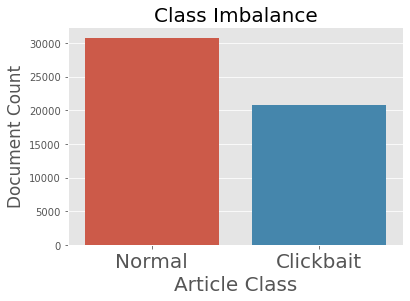

In [8]:
graph.show_class_imbalance(df, PATH = "./src/images/classimbance.png");

Class imbalance can cause the classifier to tend to predict the dominant class. In my case, this would lead to a loss of sensitivity of my model as it would predict too many headlines as being normal. 

It should be noted that `dataset1` has no class imbalance and whereas `dataset3` is imbalanced almost 3:1. In order to correct for the class imbalance, I will try upsampling, smote, class_weight='balanced' and leaving it as it is.

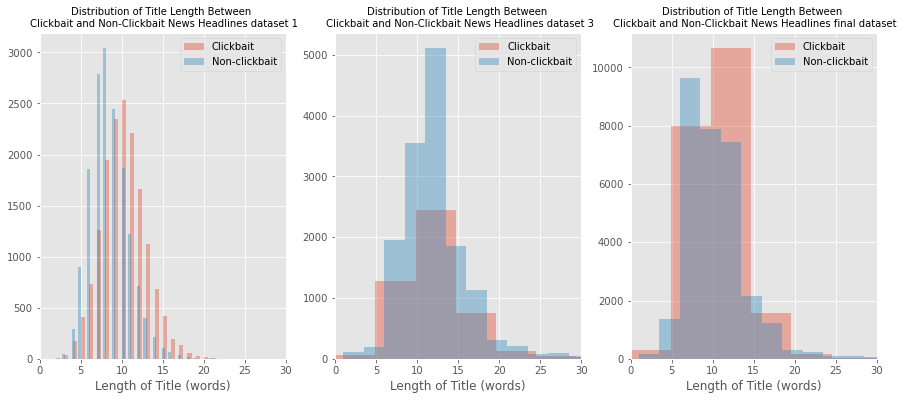

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
graph.title_lengths(df1, ax[0], content='text', x_lim=[0, 30], title='dataset 1')
graph.title_lengths(df3, ax[1], content='title', x_lim=[0, 30], title='dataset 3')
graph.title_lengths(df, ax[2], content='title', x_lim=[0, 30], title='final dataset');

# Corpus Statistics

Initially I suspected that there would be a large difference in the length of the words between click bait and non click bait headlines. To test this hypotheses, I conducted a mannwhitneyu test between classes in my primary data set.

The Levene's test assesses the null hypothesis that the the variance in between two samples are equal. Here, I first seperated my corpus into clickbait versus non-click bait and then mapped the number of words in each sentence to the a new array. I took those arrays and ran a Leven's test of equal variance. 

In [10]:
click_lengths = (df[df.target == 1].title.apply(graph.get_len))
non_lengths = (df[df.target == 0].title.apply(graph.get_len))

click_var = np.var(click_lengths)
non_var = np.var(non_lengths)


equal_var = stats.levene(click_lengths, non_lengths)

print(f"The lengths of titles had a difference in variation of {round(click_var - non_var, 2)} which was significant when run through a levene's test {equal_var}")

The lengths of titles had a difference in variation of 10.1 which was significant when run through a levene's test LeveneResult(statistic=78.71124410150307, pvalue=7.413243944769525e-19)


In [11]:
significance = stats.mannwhitneyu(click_lengths, non_lengths)
median_dif = int(round((click_lengths.median()-non_lengths.median()), 0))
print(f"The median title length between groups have a difference of {median_dif} but are statistically different from one another: p = {round(significance[1],2)}")

The median title length between groups have a difference of 0 but are statistically different from one another: p = 0.0


Though the median size of the titles did not differ, the Mann-Whitney U test determined that there was almost no chance that the probability of headline being longer or short than another is perfectly equal.

## Difference In Individual Word Lengths

Next, I wanted to look at at the average length of the words in the title. I believed that that clickbait titles use a shorter, snappier vocabulary however, journalists operate in an economy of words and it could be the case that normal headlines are longer over all.

I first found the mean word length for every document in each class and then I compared the mean between the classes using a two way students t test with unqeual variance.

Non clickbait words are on average 0.63 words longer than clickbait titles with a p value of 0.0
Results of a Mann-Whitney U test for difference was MannwhitneyuResult(statistic=188429935.5, pvalue=0.0)


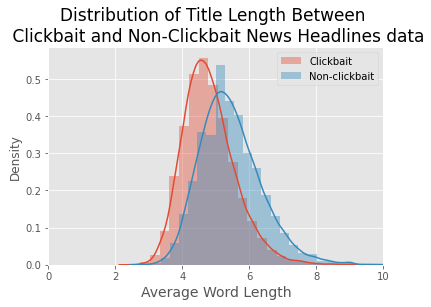

In [12]:
clickbait_words = df[df.target==1].title.apply(graph.get_average_word_length)
nonclickbait_words = df[df.target==0].title.apply(graph.get_average_word_length)
mean_difference = np.mean(nonclickbait_words) - np.mean(clickbait_words) 
p = round(stats.ttest_ind(clickbait_words, nonclickbait_words, equal_var=False)[1], 2)
print(f"Non clickbait words are on average {round(mean_difference, 2)} words longer than clickbait titles with a p value of {p}")
graph.word_lengths(df);


mP = stats.mannwhitneyu(clickbait_words, nonclickbait_words, alternative='two-sided')
print(f"Results of a Mann-Whitney U test for difference was {mP}")



As I suspected, non-click bait articles on average use slightly longer words than that of clickbait articles. Next I was interested in the content of the words. However, on visual inspection, the distributions are not drastically different from one another. Using a 

I wanted to look at the `ratio of stopwords` used in each of the of the classes. Stopwords are common english words that don't convey very much meaning (and, don't, well). In the present study, I used the NLTK stopwords in addition to some names that turned up frequently such as Trump and Obama.  In some cases, these are removed from the corpus. However I hypothesised that stopwords would be used more frequently in clickbait.  

I calculated clickbait ratio by dividing the length each title without stopwords by the same title with stopwords. To avoid a 0 division error I added 1 to the numerator and denominator. Therefore, 1 is the lowest proportion possible and represents the ratio between stop words and normal words. 

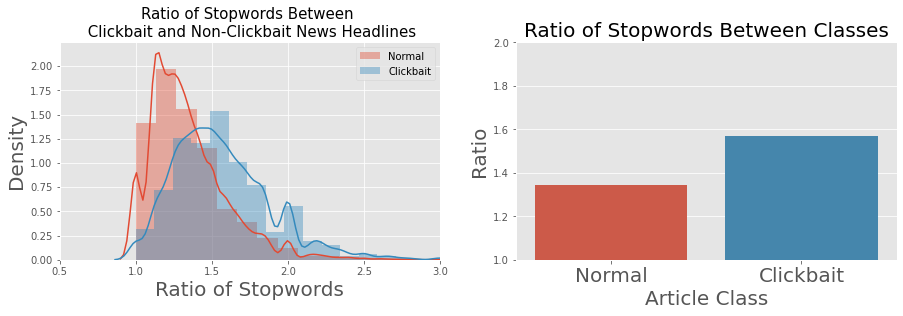

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
graph.stopword_hist(df, pp.stop_words, ax[0])
graph.stopword_bar(df, pp.stop_words, ax[1])
plt.savefig("./src/images/stopwords.png", bbox_inches="tight", transparent=True);

As I expected, the proporiton of stopwords in the click bait headlines was higher than in Normal headlines. Though clickbait isn't strictly speaking a lie, research into lying does support this finding. Truthful statements tend to have less filler words than dishonest ones. Here we see an example of that in the reduced number of stop words in the non clickbait articles.

In addition to stopwords, I am familiar with the prevelance of cardinal numbers in clickbait articles "17 reasons you have to visit jamaica" or "top 19 best hiphop songs from the 90s". These listicle articles are very common and I wanted to see if the inclusion of numbers could be a deciding factor between the classes. 

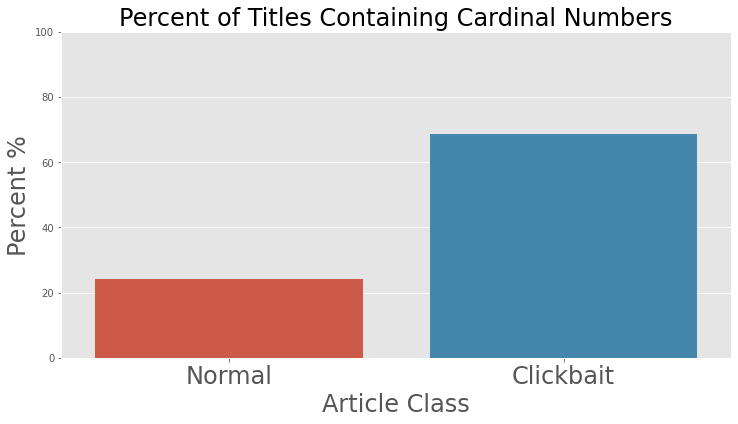

In [14]:
ax = graph.proportion_with_cardinals(df, PATH = "./src/images/cardinality.png")

70% of all clickbait titles contain cardinal numbers whereas only 20% of non-clickbait titles contain them. This is a large class divide that we can use in the model. I wonder, if the types of numbers are important. For instance, Normal news headlines will often have numbers less than 10 and also 4 digit dates. (TO DO) whereas I would expect click bait articles to be exclusively 1-100. I wouldn't expect to see any years in there at all.


Next, I will look at the actualy vocabulary of each class, to do this, I will first remove stopwords and then create and visualize frequency dictionaries.

# Use of Punctuation: TODO

I am interested in the types of punctuation used between classes. 

pseudo code:

- create a frquency dictionary for each char in string.punctuation for each class
- visualize each class 
- profit

# Frequency Dictionary Analysis

I was interested in the most common words used between classes. The primary method of text mining I use will be term frequency inverse document frequency. Therefore, the frequency of specific words is of interest to me.

I used custom functions to create frequency dictionaries without stopwords and then graphed the results using nltk.probability.Freqdict.

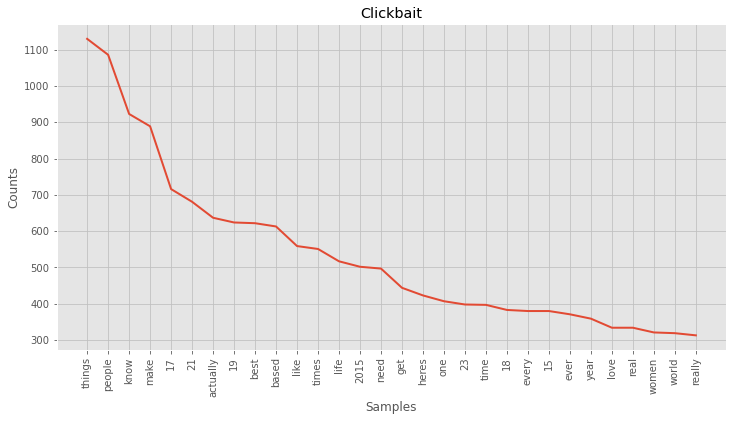

Current Vocab size is = 16399


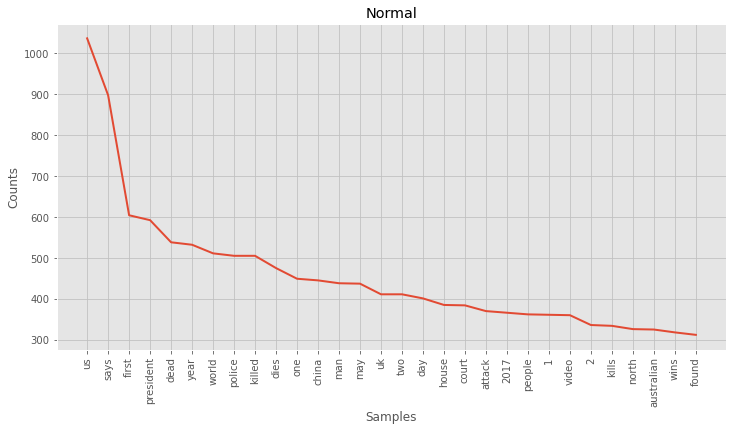

Current Vocab size is = 26476


In [15]:
# Remove stopwards
df['no_stops'] = df.title.apply(pp.remove_stopwords)

# Create frequency dictionaries
click_dict = graph.get_vocab_length(df[df.target == 1].no_stops, title="Clickbait")
normal_dict = graph.get_vocab_length(df[df.target == 0].no_stops, title="Normal")

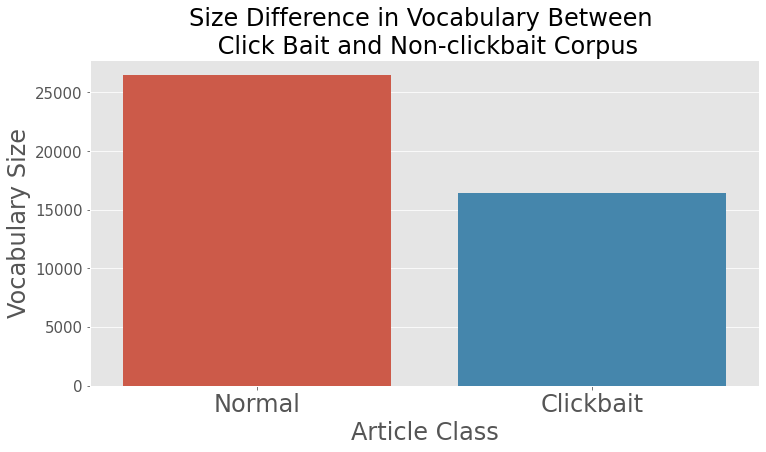

In [16]:
# Vocabulary check
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=["Normal","Clickbait"], y=[ len(normal_dict),len(click_dict)])
ax.set_ylabel("Vocabulary Size")
plt.title("Size Difference in Vocabulary Between \n Click Bait and Non-clickbait Corpus", size=24)
plt.xticks(size=24)
plt.yticks(size=15)
plt.ylabel("Vocabulary Size" ,size=24)
plt.xlabel("Article Class", size=24)
plt.savefig('./src/images/vocabulary.png', bbox_inches="tight", transparent=True);

Normal headlines use a wide variety of words whereas clickbait titles use a restricted set of words. This is likely due to the limited number of subjects that clickbait covers. Usually, consumerism, pop culture and entertainment whereas Normal headlines can cover almost anything. This means that there will be a lot of unique words that only ever occur in Normal hedlines. This is strong evidence to use something like Naive Bayes are A random forest classifier. 

Let's look closer at the kinds of words that are used in each class by creating word clouds. Word clouds visualize the frequency of words by their relative size.


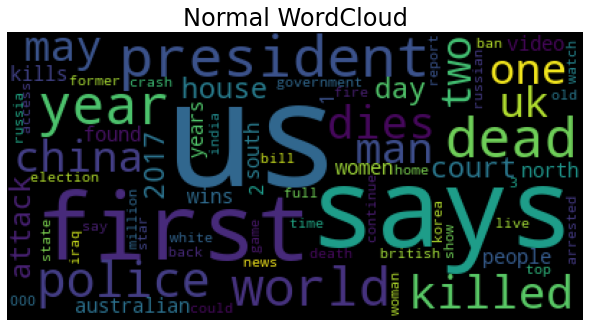

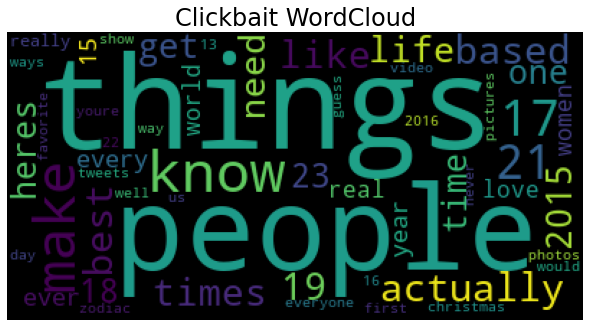

In [17]:
graph.generate_wordcloud(normal_dict, title = "Normal WordCloud", PATH = "./src/images/NORMALwc.png")

graph.generate_wordcloud(click_dict, title = "Clickbait WordCloud", PATH = "./src/images/CLICKwc.png")

What stood out to me immediately was the generic use of language in clickbait as appposed to the specificity of language in Normal headlines. But let's be more specific about that. I am interested in visualizing the differences between group in vocabularly used. That is, the most frequently used words or tokens that are in click bait headlines but are not normal headlines.


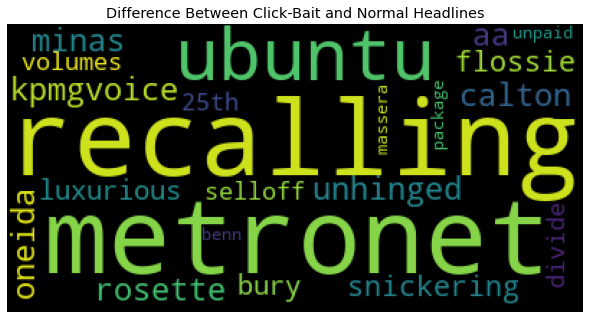

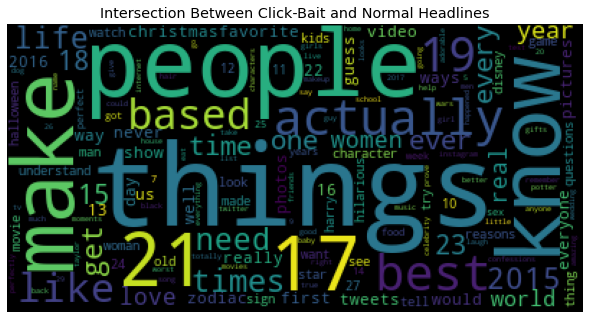

In [18]:
# Visualize the differences and the intersect between normal and clickbait headlines
graph.visualize_intersection(df)

The top image shows the words that are in click headlines but not found in Normal headlines. The tone of the words is somber. The bottom image is the intersection between the the vocabularies between classes. Non specific wording, numbers and superlatives. 

# Part of Speech Tagging

I wondered if the there was a difference in the way words were used a part of speech. Part of speech tagging is a way of marking up a corpus such that each word is labelled with the part of speech that it occupies (noun, verb, adjective etc). To do this, I used TextBlob which is a wrapper class for nltk.

In [19]:
def get_tags(corpus):
    return [TextBlob(word).tags for word in corpus.split()]

In [20]:
# Extract the corpus of words from each class
norm_corpus = " ".join(df[df.target == 0].no_stops.to_list())
click_corpus = " ".join(df[df.target == 1].no_stops.to_list())

In [21]:
# Tag the corpus with part of speech tagging using Textblob
norm_tag = get_tags(norm_corpus)
click_tag = get_tags(click_corpus)

In [22]:
# Extract out just the parts of speech from the text blob
norm_tag_list = []
for i, item in enumerate(norm_tag):
    try:
        norm_tag_list.append(item[0][1])
    except:
        continue
        
click_tag_list = []
for i, item in enumerate(click_tag):
    try:
        click_tag_list.append(item[0][1])
    except:
        continue

In [23]:
# Generate pos dictionaries
norm_tag_dict = graph.freq_of_specific_words(norm_tag_list, set(norm_tag_list))
click_tag_dict = graph.freq_of_specific_words(click_tag_list, set(click_tag_list))

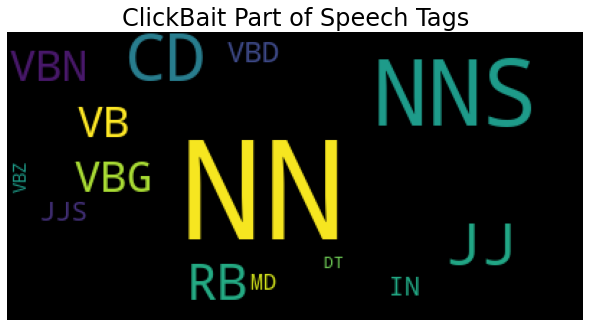

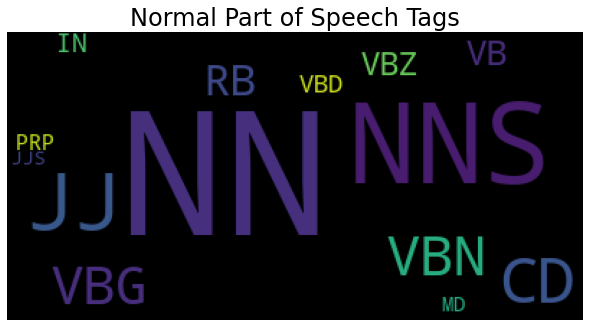

In [24]:
# Generate word clouds
graph.generate_wordcloud(click_tag_dict, title="ClickBait Part of Speech Tags")

graph.generate_wordcloud(norm_tag_dict, title="Normal Part of Speech Tags")

A word cloud here is not very revealing, I think bar plots would be better suited for showing the distribution of part of speech tags. Both classes are dominated by Nouns but is hard to see any other relationships

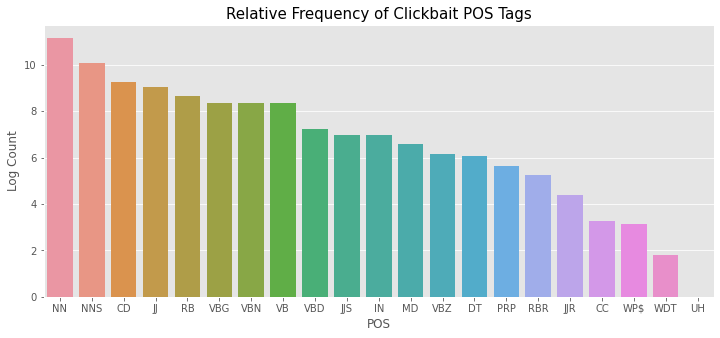

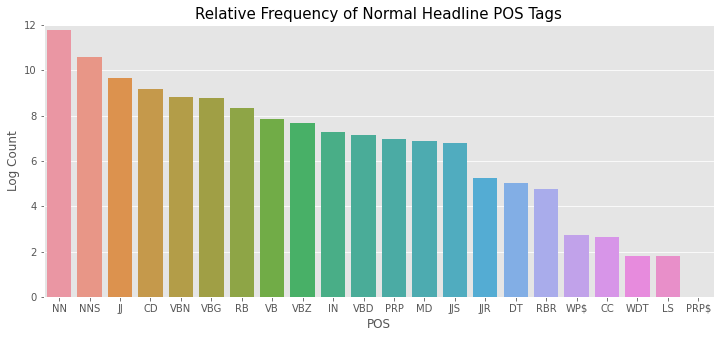

In [25]:
# Generate sorted dictionaries 
click_pos_df = pd.DataFrame(click_tag_dict.items(), columns = ['POS', "Count"]).sort_values('Count', ascending=False)
norm_pos_df = pd.DataFrame(norm_tag_dict.items(), columns = ['POS', "Count"]).sort_values('Count', ascending=False)

click_pos_df['Log Count'] = np.log(click_pos_df.Count)
norm_pos_df['Log Count'] = np.log(norm_pos_df.Count)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (12,5))
sns.barplot(data=click_pos_df, x='POS', y = 'Log Count', ax=ax)
plt.title("Relative Frequency of Clickbait POS Tags", Size=15)
plt.savefig("./src/images/clickPOS.png", bbox_inches='tight' )

fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (12,5))
sns.barplot(data=norm_pos_df, x='POS', y = 'Log Count', ax=ax)
plt.title("Relative Frequency of Normal Headline POS Tags", Size=15)
plt.ylim(0,12);

# Key Differences in Part of Speech Tags

### Realtively more important tags for clickbait
- JJS: The Superlative eg Biggest! Best! Funnest!
- PRP: Personal Pronouns eg I, he, she
- RB: Adverb eg Very, Silently, Colorfully. 
- VBG: verb, gerund/present participle taking. eg **Playing** gameboy is fun!
 
I was surprised to learn that the relative structure of the two classes was similar in the aggregate. When we see click bait, it is almost immediately apparent whether it is being sensationalist and eye catching, however, from the parts of speech used, they are on average quite similar. This highlights the difficulty of the problem


The parts of speech tags are not entirely different to each other. That is, there is no unique part of speech to click bait that would set it apart. However, I will include them in the model as it is difficult to tell what a model may or may not be able to pick up on.


## Sentiment Analysis

I wanted to look at sentiment scores between the classes as a potential feature to explolit for classification. News headlines are supposed to be sentiment neutral overall, however I suspected there may be key differences. My hypothesis was that clickbait headlines would have higher variance in sentiment.

In [26]:
analyzer = SentimentIntensityAnalyzer()
click_polarity = df[df.target==1].title.apply(modelling.get_polarity)
normal_polarity = df[df.target==0].title.apply(modelling.get_polarity)

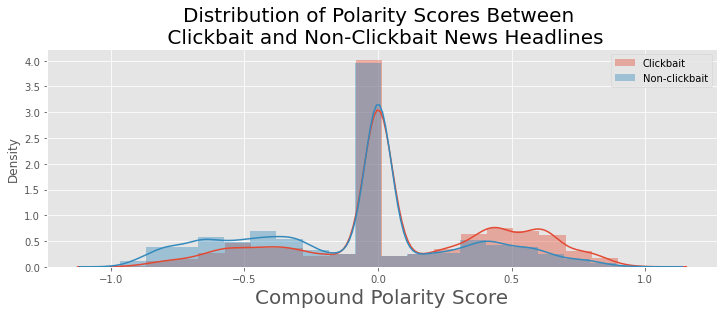

In [27]:
fig, ax = plt.subplots(figsize = (12,4))
for a, b in zip([click_polarity, normal_polarity], ['Clickbait', 'Non-clickbait']):
    sns.distplot(a, bins=20, ax=ax, kde=True, label=b)
    plt.legend()
ax.set_xlabel("Compound Polarity Score", size = 20)
ax.set_title("Distribution of Polarity Scores Between \n Clickbait and Non-Clickbait News Headlines", size = 20)
plt.savefig("./src/images/sentiment.png", bbox_inches="tight", transparent = True);

## Subjectivity Analyis

### TODO

The vast majority of headlines fall with the central or neutral range. However, the number of clickbait headlines that are net positive or greater than 0.5 is greater. This came as a surprise as I would have thought that clickbait would be more extreme in both directions, however, that was not the case with a near perfect mirror image of sentiment distrubtion between classes.


# Baseline modelling

- Naive Bayes
- Logistic Regression

I will use tf-idf after a train test split in conjunction with a decision tree, logistic regressor and a bayes classifier to find suitable baseline model.

Without any hyperparamater tuning, The baseline models performed very well poorly on f1 scores (0.8). In particular, when we compare them to a dummy classifier we see a large increase over random. The best performaing model without any hyperparamater tuning was Naive Bayes.  

Naive Bayes uses bayesian inference to predict the probability of a headline belonging to a particular class **given** it's contents. The assumption of Naive bayes is independence of all of the ngrams. This is not necessarily the case in natural langauge processing however in this instance it performed very well.

Models: 		 Dummy		 Naive Bayes		Logistic Regression
Training f1 scores:(0.49992147008010046, 0.9946969399379346, 0.9816925459671976) 

 Testing f1 Scores: (0.5007795447458685, 0.977407126611069, 0.9637305699481865)


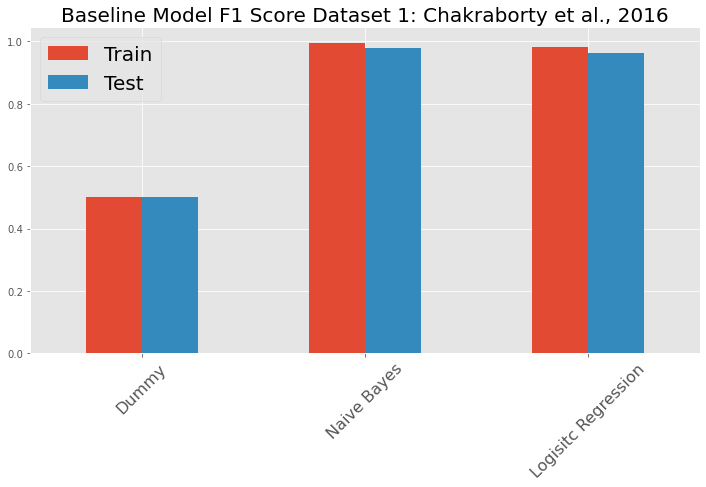

In [28]:
# Baseline on only the Chakbroty data
bayes1, log1, scores1 = modelling.run_baselines(df[df.dataset==1]);
baseline = pd.DataFrame(scores1).T
baseline.columns = ['Train', 'Test']
baseline.index = ['Dummy', "Naive Bayes", "Logisitc Regression"]
fig, ax = plt.subplots(figsize=(12,6))

baseline.plot(kind='bar', ax=ax)
plt.xticks(rotation=45, size=16)
plt.title("Baseline Model F1 Score Dataset 1: Chakraborty et al., 2016", size=20)
plt.legend(loc=2, prop={'size': 20});

The results from only data set 1 appear to be too good to be true. However, I took great pain in creating the data set to insure no data leakage was present. For reasons discussed later, I think that the method of labelling used between the datasets was inconsistent enough to produce the differences that we are going to see moving forward.

Models: 		 Dummy		 Naive Bayes		Logistic Regression
Training f1 scores:(0.24302736676705514, 0.46574795286598764, 0.47880781885039675) 

 Testing f1 Scores: (0.24946236559139787, 0.06211180124223602, 0.40301886792452835)


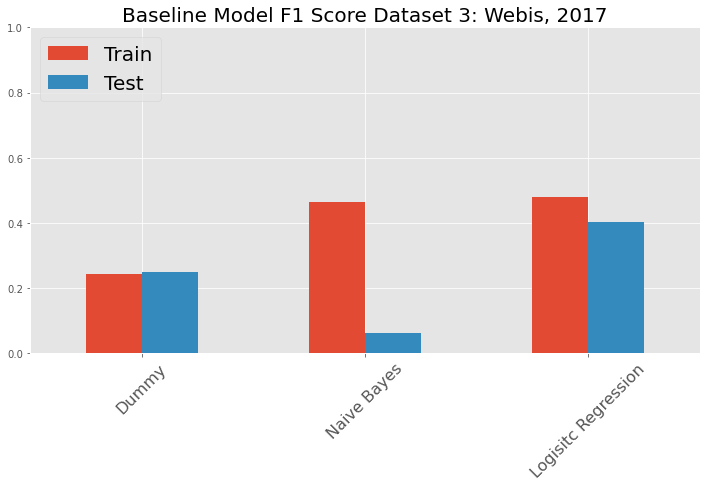

In [29]:
# Baseline on only the Webis 2017 data
bayes2, log2, scores2 = modelling.run_baselines(df[df.dataset==3])

baseline = pd.DataFrame(scores2).T
baseline.columns = ['Train', 'Test']
baseline.index = ['Dummy', "Naive Bayes", "Logisitc Regression"]
fig, ax = plt.subplots(figsize=(12,6))
ax.set_ylim([0,1])
baseline.plot(kind='bar', ax=ax)
plt.xticks(rotation=45, size=16)
plt.title("Baseline Model F1 Score Dataset 3: Webis, 2017", size=20)
plt.legend(loc=2, prop={'size': 20});

However, dataset 3 (Webis 2017) produces terrible results in isolation. Probably due to the fact that the data collection method was so different. They asked the participants to select out of 5 how clickbaity the headline was. The data sets did not seem that different when it came to EDA (see `notebooks/EDA/exploration`). 

From the above model it seems that how people treat a likart scale vs a dichotomous variable changes the psychometrioc evaluation of the headline. This will warrant post mvp research. 


For now, I will continue with all of the data together. Ultimately, I plan on making a model using a tfidf trained on all of the words but then fit the model only using the Chakbroty data.

### Baseline Combined dataset model

Models: 		 Dummy		 Naive Bayes		Logistic Regression
Training f1 scores:(0.4012556216232531, 0.9412342948422572, 0.8972386272944932) 

 Testing f1 Scores: (0.412289156626506, 0.864952571143285, 0.8608706255334716)


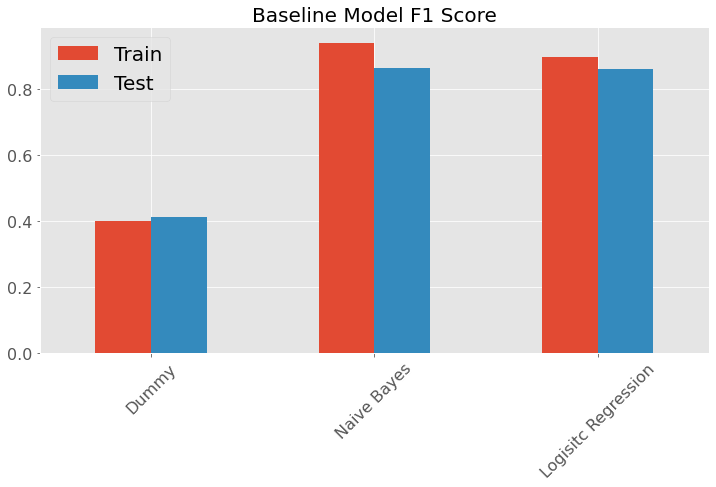

In [30]:
bayes, log, scores3 = modelling.run_baselines(df)
baseline = pd.DataFrame(scores3).T
baseline.columns = ['Train', 'Test']
baseline.index = ['Dummy', "Naive Bayes", "Logisitc Regression"]
fig, ax = plt.subplots(figsize=(12,6))

baseline.plot(kind='bar', ax=ax)
plt.xticks(rotation=45, size=16)
plt.yticks(size=16)
plt.title("Baseline Model F1 Score", size=20)
plt.legend(loc=2, prop={'size': 20})
plt.savefig("./src/images/baselinef1.png", bbox_inches='tight', transparent=True);

## Dataset 3 is pulling the rest of the numbers down while dataset 1 is pulling the numbers up.

I find it interesting that the results are as high as they given how badly one data set performs on the baseline. I think that the model learned from the high quality data and was able to transfer that learning to poorly labelled items. I wonder if the decrease in f1 is exactly what we would expect given how poorly the model performed on dataset3 or is it completely different? If it is different, then there is evidence that the first data set is 'transfering' some of its learning to the third.


## Full analysis of just dataset 1: Chakraborty

I didn't implement any of my preprocessing, I just used TfidfVectorizer and it's inbuilt tokenizer. I then used a Bernoulli bayes instead of multinomial bayes as it is better suited for dichotmous variables. Considering how sparse my data is, I wanted a model that would maximise the impact of having binomial data, which to my mind, sparse data approximates.

In [31]:
tfidf = TfidfVectorizer(ngram_range=(1,3))
X = df[df.dataset==1]['title']
y = df[df.dataset == 1]['target']
X_train_bayes, X_test_bayes, y_train_bayes, y_test_bayes = train_test_split(X, y, 
                                                                            test_size = 0.2,
                                                                            random_state=42)

#tfidf fit
tfidf.fit(X_train_bayes)
X_train_tfidf = tfidf.transform(X_train_bayes)
X_test_tfidf = tfidf.transform(X_test_bayes)

# Bayes
bayes_clf = BernoulliNB(alpha=0.3, fit_prior=True)

bayes_clf.fit(X_train_tfidf, y_train_bayes)
y_hat_bayes=bayes_clf.predict(X_test_tfidf)
y_hat_train_bayes = bayes_clf.predict(X_train_tfidf)
print(f"Train F1 score for Chakraborty: {f1_score(y_train_bayes, y_hat_train_bayes)}")
print(f"Test F1 score for Chakraborty: {f1_score(y_test_bayes, y_hat_bayes)}")

Train F1 score for Chakraborty: 0.9992229992229993
Test F1 score for Chakraborty: 0.9812409812409812


### Chakraborty was excellently labelled

It turns out that the if the dataset is labelled correctly, predicting on the class is relatively simple. This is advantageous for me as I plan on making a google chrome extension that can parse out and remove clickbait which is a challange in an of itself.

## Confusion Matrices and ROC Plots

I will be using these two visualizations consitently in order to evaluate the models so it is worth spending some time explaining exactly what they show.


#### Confusion Matrix

This is a way of representing all of the predictions made by the model in relation to the actual labels of the model. The bottom left hand side of the matrix represents false negatives, headlines that were actually clickbait but my model labelled as negative. On the top right are the false positives, headlines that were actually normal but my model predicted them to be clickbait. Using this matrix, it is then possible to calculate precision, recall and f1 scores.

#### ROC plot

The Receiver operating characteristic shows the ratio between True positives and false positives accross a variety of thresholds. As the model improves, the curve will appear to move up to the left. This is intuitive. With a really good model, you would have a perfect true positive rate but very small or nonexistant false positive rate. On the other hand, if the model performed no better than guessing, the False postivie and True positive rates would be equal and the ROC curve would appear to be linear. 

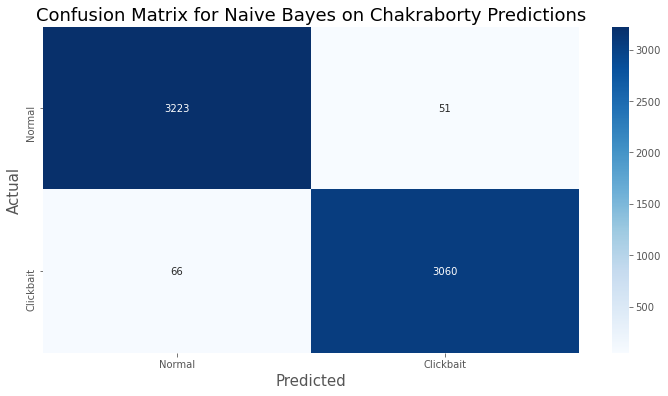

AUC: 0.9976919297858894


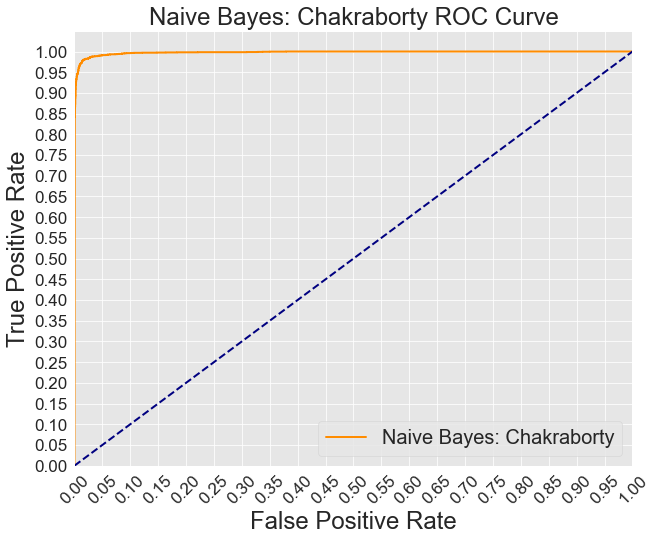

In [32]:
graph.plot_cmatrix(y_test_bayes, y_hat_bayes,model = 'Naive Bayes on Chakraborty', PATH='./src/images/Chakraconfusion.png')

graph.plot_roc_curve(y_test_bayes, bayes_clf.predict_proba(X_test_tfidf)[:,1], model="Naive Bayes: Chakraborty",PATH='./src/images/ChakraROC.png' )

In [33]:
# Pickle the model
filehandler = open("./src/models/model0.1.pickle", "wb")
pickle.dump(bayes_clf, filehandler)
filehandler = open("./src/models/tfidf0.1.pickle", "wb")
pickle.dump(tfidf, filehandler)

**I Saved this model as ./src/models/model1.1.pickle** 

The strength of this model makes me wonder if it is legitmate. I have exhaustively searched for sources of data leakage yet so far I have not discover anything that could lead to this level of leakage. I think that this data was labelled accurately and consistently. 

### Include the features that I discovered during EDA
- title length, words and characters
- ratio of stopwords
- presence of a number 
- total punctuation used

I will first run the data through a model and after that I will take the predictions, concatenate them with my engineered features and run that through the model again in the hopes that some of them will be over turned.

### Engineer features based on EDA

In [34]:
features = modelling.generate_features(df)
feature_df = pd.DataFrame(features).T
feature_df.columns = ['average_len','length', 'stop_proportion', 'punct_prop', 'exclamation_', 'get_polarity_']

## Feature Union
#### Concatenate the features onto the predictions and run it through a logistic regression.

The idea here is to use the output of the Bernoulli Naive Bayes as a feature along with the engineered features to try and acheive an increase in f1 score. The Logic is to run the train data through the Bernoulli, then generate the features, concatenate the features onto the predictions, fit a logistic regression onto that and then predict on the test data using the same method.

In [35]:
# Generate features of the X_train_bayes
feature_df = pd.DataFrame(modelling.generate_features((X_train_bayes))).T
feature_df.columns = ['average_len','length', 'stop_proportion', 'punct_prop', 'exclamation_', 'get_polarity_']

# Create a combined feature df with training predictions                 
fy = pd.DataFrame(y_hat_train_bayes)
fX = pd.concat([feature_df, fy])

# Apologies for this sloppy code, but I was unable to concatenate the dataframes
Xf_train = fX.reset_index().merge(fy, left_index=True, right_index=True)
Xf_train.drop(columns = ['index', '0_x'], inplace=True)

# ==================== Repeat process for testing data =====================

y_hat_test_bayes=bayes_clf.predict(X_test_tfidf)

# Generate features of the X_test
feature_df = pd.DataFrame(modelling.generate_features(pd.Series(X_test_bayes))).T
feature_df.columns = ['average_len','length', 'stop_proportion', 'punct_prop', 'exclamation_', 'get_polarity_']

# Create a combined feature df with training predictions                 
fy=pd.DataFrame(y_hat_test_bayes)
fX = pd.concat([feature_df, fy])

# Merge the predictions onto the features
Xf_test = fX.reset_index().merge(fy, left_index=True, right_index=True)
Xf_test.drop(columns = ['index', '0_x'], inplace=True)  

In [36]:
log_clf = LogisticRegression(class_weight='balanced')

log_clf.fit(Xf_train, y_train_bayes)

y_hat_log__train = log_clf.predict(Xf_train)
y_hat_test_eng = log_clf.predict(Xf_test)
f1_score(y_train_bayes, y_hat_train_bayes), f1_score(y_test_bayes, y_hat_test_eng)

(0.9992229992229993, 0.9812409812409812)

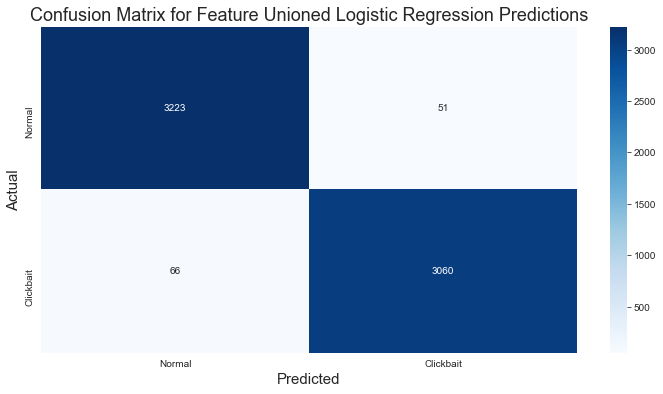

AUC: 0.9854017636775292


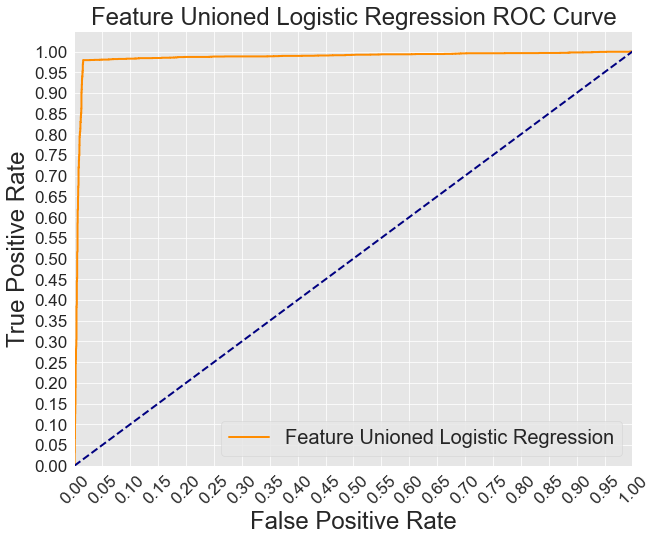

In [37]:
graph.plot_cmatrix(y_test_bayes, y_hat_test_eng, model="Feature Unioned Logistic Regression")
graph.plot_roc_curve(y_test_bayes, log_clf.predict_proba(Xf_test)[:,1], model = "Feature Unioned Logistic Regression")

This is a bizzare lookling ROC curve. It's actually slight worse than wiothout the added variables. However, I am deeply suspicious of the this model. It is too good to be true. I need to put it into small scale production and test it before I will feel confindent in using it. For now, I think that the best course of action is to move ahead with the combined data set.

Let's repeat the process on the Webis dataset and plot the ROC curves together

In [38]:
tfidfw = TfidfVectorizer(ngram_range=(1,3))
# Select only 
X = df[df.dataset==3].title
y = df[df.dataset == 3].target
X_train_bayesw, X_test_bayesw, y_train_bayesw, y_test_bayesw = train_test_split(X, y, 
                                            test_size = 0.2,
                                                    random_state=42)
#tfidf
tfidfw.fit(X_train_bayesw)
X_train_tfidfw = tfidfw.transform(X_train_bayesw)
X_test_tfidfw = tfidfw.transform(X_test_bayesw)

# Bayes
bayes_clfw = BernoulliNB(alpha=0.3, fit_prior=True)

bayes_clfw.fit(X_train_tfidfw, y_train_bayesw)
y_hat_bayesw=bayes_clfw.predict(X_test_tfidfw)
y_hat_train_bayesw = bayes_clfw.predict(X_train_tfidfw)
print(f"F1 score for Webis {f1_score(y_test_bayesw, y_hat_bayesw)}")

F1 score for Webis 0.2508417508417508


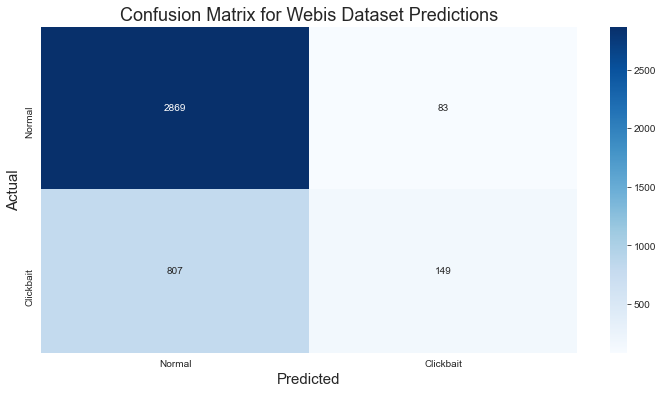

AUC: 0.7404553752650498


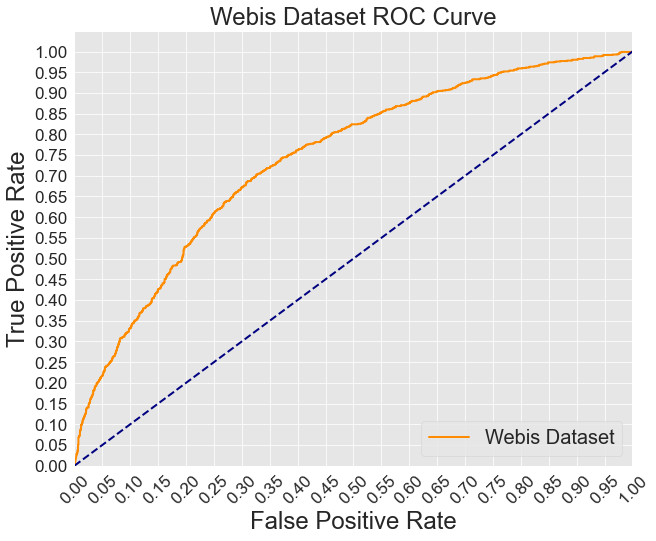

In [39]:
graph.plot_cmatrix(y_test_bayesw, y_hat_bayesw, model='Webis Dataset', PATH="./src/images/Webisconfusion.png")
graph.plot_roc_curve(y_test_bayesw, bayes_clfw.predict_proba(X_test_tfidfw)[:,1], model="Webis Dataset", PATH="./src/images/WebisROC.png")

### Webis is barely predictable whereas Chakbraborty is almost too predictable

The Webis dataset is far too selective in it's predictions. On the testing data, it only classified 150 of the 900 click bait articles as such. After looking closer into the actual headlines, when I randomly sampled groups of 20 headlines, I found that in every single groupd I could identify multiple misclassifications. This is cause for some alarm. 

## Here I discuss some of the reasons for the stark difference in predictability Between Datasets

The issue here is that there are potentially several differences in how the data was collected and labelled:
 - Mechanical Turks (paid) vs University Student Volunteers
 - Likart scale (0-5 clickbate scale), dichotomous categroical (yes or no)
 - 25 different news sources vs 6
 - Potential for subjective and cultural differences between what groups consider to be clickbait.
 
There are a lot of reasons why the data is behaving so differently in my model. Paid mechanical Turks, ironically in this case are paid per click. Meaning, they have no  interest in the outcome of the study apart from being paid. On the other hand, the Chakraborty volunteers were almost certainly unpaid undergraduate volunteers at the Indian Institute of Technology, potentially working in the same department. Even if all of that was false apart from them being unpaid volunteers,we still know that they had a vested interest in the success of the study outside of financial compensation.
 
There have been studies conducted on the psychometric differences between likart scales and dichotomous categorical questionnaires. In most cases, likart scales are used for self reporting of subjective qualia: 
 - How much pain are you in?
 - How likely are you to reccomend this restaurant?
 - How happy are you right now?
 
 In these contexts, the questions are predominantly about self reflection. But when put in the context of classifiying click bait:
 - How clickbaity is this headline?
     - "Former Employees Of Large Corporations Are Sharing Juicy Secrets Customers Don't Know And It's A Lot To Process"

It becomes realy difficult to quantify something like clickbait. It is clear to me that it is click bait (perhaps you disagree) but is it REALLY clickbaity? Would it be a 5 out of 5 or a 3 out of 5? The truth is that clickbait is a relative term. Maybe you just saw 10 articles in a row from the New York Times and then this headline, you would vote that it is more clickbaity. On the other hand, if you were looking at nothing but clickbait all day, this one may not seem as extreme. Questions like this have the potential introduce noise and a lot of potential contextual bias into the situation.

Then we have the data acquisition itself. Chakraborty sourced all of their headlines from the actual websites, scraping articles daily directly from the websites. They had a fixed number of news agency that they were interested in looking into. Webis on the other hand used Twitter to obtain URLS to scrape from and included 25 different publishers. Therefore, it is possible that my classifier is simply predicting headline styles between publishers, the more publishers that I include in my dataset the less accuracte the overall prediction would be. This is a great question that I would love to pursue post MVP.

Then the subjectivity of clickbait classification. In Chakbraborty et al., they noticed that when they had 200 volunteers judge 200 headlines (100 click bait and 100 normal) they discovered that the overall agreement could be as low as 20% on some articles. Is this caused by large differences in personal preference and some learned threshold for clickbait tolerance, or to my second point, is it again just the order the data was presented in. They did not mention what order the headlines were presented in so we cannot know if it played a part but we also can't know that it didn't.

##### I will continue on with iterating models on the combined data set however, my chrome extension will only use the model trained on the Chakbraborty Data.

## Optimised Naive Bayes

Naive bayes is the fastest of the models. Its assumes that all of the features are independent from one another which for words isn't necessarily true, however it works very well on my data set, so I will iterate over it and produce the best results possible

I eveventually settle on Multinomial Naive Bayes Classifier with a categorical smoothing of 0.35

In [40]:
# Instantiate my vectoriser
tfidf1 = TfidfVectorizer(ngram_range=(1,2))
# Use the entire dataset
X = df.title
y = df.target
X_train_bayes1, X_test_bayes1, y_train_bayes1, y_test_bayes1 = train_test_split(X, y,
                                                                                test_size = 0.2,
                                                                                random_state=42)
#tfidf
tfidf1.fit(X_train_bayesw)
X_train_tfidf1 = tfidf1.transform(X_train_bayes1)
X_test_tfidf1= tfidf1.transform(X_test_bayes1)

# Bayes
bayes_clf1 = BernoulliNB(alpha=0.3)

bayes_clf1.fit(X_train_tfidf1, y_train_bayes1)
y_hat_bayes1=bayes_clf1.predict(X_test_tfidf1)
y_hat_train_bayes1 = bayes_clf1.predict(X_train_tfidf1)
print(f"Test F1 score for Model 1 is {f1_score(y_test_bayes1, y_hat_bayes1)}")
cross_val_mean = np.mean(cross_val_score(bayes_clf1, X_train_tfidf1, y_train_bayes1, cv=10))
print(f"Cross Validation score: {cross_val_mean}")

Test F1 score for Model 1 is 0.8455719771907367
Cross Validation score: 0.875357749211739


## What I changed:

- Stratified that data in with respect to the dataset origin.
- Multinomial Bayes instead of Bernoulli
- Left the stopwords in the model
- I removed contractions
- Lowercased everything
- Mapped non ascii chars to to the ascii equivelant

# Best Model: Multinomial Naive Bayes

In [41]:
# Instantiate my vectoriser
tfidf1 = TfidfVectorizer(ngram_range=(1,2))
# Use the entire dataset
X = df.title.apply(pp.preprocess)
y = df.target
X_train_bayes1, X_test_bayes1, y_train_bayes1, y_test_bayes1 = train_test_split(X, y,
                                                                                test_size = 0.2,
                                                                                random_state=42, stratify=df.dataset)
#tfidf
tfidf1.fit(X_train_bayes1)
X_train_tfidf1 = tfidf1.transform(X_train_bayes1)
X_test_tfidf1= tfidf1.transform(X_test_bayes1)

# Bayes
bayes_clf1 = MultinomialNB(alpha=0.35)

bayes_clf1.fit(X_train_tfidf1, y_train_bayes1)
y_hat_bayes1=bayes_clf1.predict(X_test_tfidf1)
y_hat_train_bayes1 = bayes_clf1.predict(X_train_tfidf1)
print(f"Train F1 score for Model 2 is {f1_score(y_train_bayes1, y_hat_train_bayes1)}")
print(f"Test F1 score for Model 2 is {f1_score(y_test_bayes1, y_hat_bayes1)}")
print(f"Test accuracy score for Model 2 is {accuracy_score(y_test_bayes1, y_hat_bayes1)}")

# Cross validate the training
cross_val_mean = np.mean(cross_val_score(bayes_clf1, X_train_tfidf1, y_train_bayes1, cv=10, scoring = 'f1'))
print(f"Cross Validation train score: {cross_val_mean}")

cross_val_mean = np.mean(cross_val_score(bayes_clf1, X_test_tfidf1, y_test_bayes1, cv=10, scoring = 'f1'))
print(f"Cross Validation test score: {cross_val_mean}")

Train F1 score for Model 2 is 0.9589066059225512
Test F1 score for Model 2 is 0.874111552824961
Test accuracy score for Model 2 is 0.8986224291812185
Cross Validation train score: 0.8632780049484807
Cross Validation test score: 0.8568970927996329


In [42]:
# Pickle the model
filehandler = open("./src/models/model2.1.pickle", "wb")
pickle.dump(bayes_clf1, filehandler)
filehandler = open("./src/models/tfidf2.1.pickle", "wb")
pickle.dump(tfidf1, filehandler)

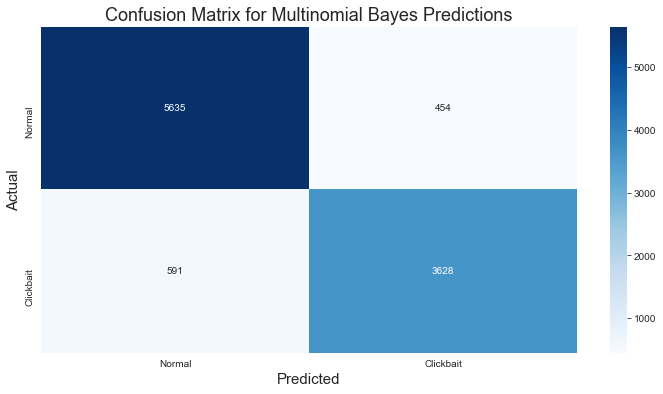

AUC: 0.9540568943152669


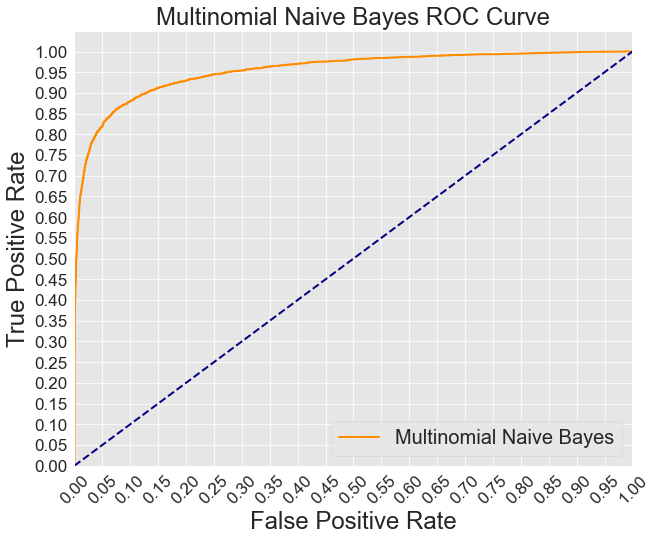

In [43]:
graph.plot_cmatrix(y_test_bayes1, y_hat_bayes1, model = 'Multinomial Bayes')
graph.plot_roc_curve(y_test_bayes1, bayes_clf1.predict_proba(X_test_tfidf1)[:,1], PATH="./src/images/Multibayes.png", model="Multinomial Naive Bayes")

This model is simple and fast. However, No matter how hard I tried, I was unable to drive down the false positive and false negative rates using a multinomial bayes classifier. Sill, 0.88 is respectablle

I wondered if a more complext model would be capable of improving on the score. The first model that I wanted to iterate over was Logistic regression. As a baseline model it performed well and I thought that I may be able to bring those scores up. 

## Logistic Regression with Cross Validation

In [86]:
#Used the same test train split but created a new tfidf vectorizer to optimise on Logistic Regression)
log_clf1 = LogisticRegressionCV(cv=10, n_jobs=-1, scoring='f1', verbose = 0)

log_clf1.fit(X_train_tfidf1, y_train_bayes1)
y_hat_log1=log_clf1.predict(X_test_tfidf1)
y_hat_train_log1 = log_clf1.predict(X_train_tfidf1)
print(f"Train F1 score for Model 2 is {f1_score(y_train_bayes1, y_hat_train_log1)}")
print(f"Test F1 score for Model 2 is {f1_score(y_test_bayes1, y_hat_log1)}")

cross_val_mean = np.mean(cross_val_score(log_clf1, X_train_tfidf1, y_train_bayes1, cv=10))
print(f"Cross Validation score: {cross_val_mean}")

Train F1 score for Model 2 is 0.9973691372584595
Test F1 score for Model 2 is 0.8656859227365148
Cross Validation score: 0.8586746486797144


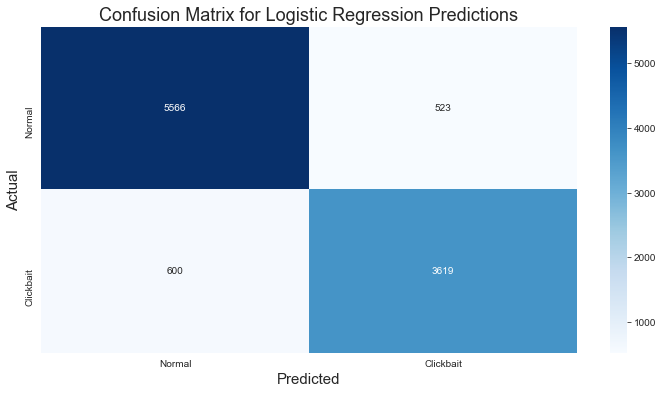

AUC: 0.9494290097067318


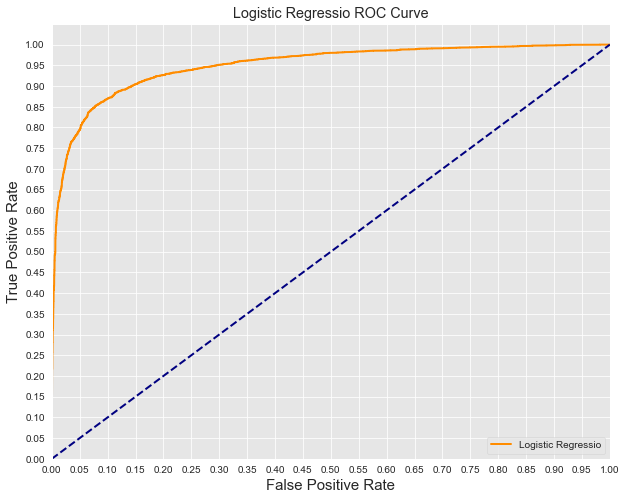

In [87]:
graph.plot_cmatrix(y_test_bayes1, y_hat_log1, model = 'Logistic Regression')
graph.plot_roc_curve(y_test_bayes1, log_clf1.predict_proba(X_test_tfidf1)[:,1], PATH="./src/images/LogisticRegression.png", model = 'Logistic Regressio')

In [46]:
# Pickle the model
filehandler = open("./src/models/model3.1.pickle", "wb")
pickle.dump(log_clf1, filehandler)
filehandler = open("./src/models/tfidf3.1.pickle", "wb")
pickle.dump(tfidf1, filehandler)

## Support Vector Machine with a Linear Kernel

Past work has indicated that SVM is a highly effective model for classification of clickbait and natural language processing classification problems in general. However, unless it offers substantial improvements over simply Naive Bayes I will not use it. SVM is slow and if I am wanting to put my model into production, the model needs to be as lightweight and fast as possible.

In [47]:
from sklearn.svm import SVC

svm_clf= SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True)

In [44]:
X = df.title
y = df.target
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size = 0.2,
                                            random_state=42,
                                            ) # To insure that data sets are equally represente
# Clean the data
X_train = X_train.apply(pp.preprocess)
X_test = X_test.apply(pp.preprocess)

# Instantiate my tfidf Vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), 
                        max_features = 100000) # Reduce the feature space. 

#tfidf
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

(51538,) (51538,)


In [49]:
import time
start_time = time.time()
svm_clf.fit(X_train_tfidf, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 873.2575600147247 seconds ---


In [50]:
start_time = time.time()
y_hat_svm_tr = svm_clf.predict(X_train_tfidf)
f1_score(y_train, y_hat_svm_tr)
print("--- %s seconds ---" % (time.time() - start_time))

--- 50.404025077819824 seconds ---


In [51]:
start_time = time.time()
y_hat_svm_te = svm_clf.predict(X_test_tfidf)
f1_score(y_test, y_hat_svm_te)
print("--- %s seconds ---" % (time.time() - start_time))

--- 12.311753988265991 seconds ---


In [52]:
f1_score(y_train, y_hat_svm_tr), f1_score(y_test, y_hat_svm_te)

(0.9488561135572867, 0.8572139303482587)

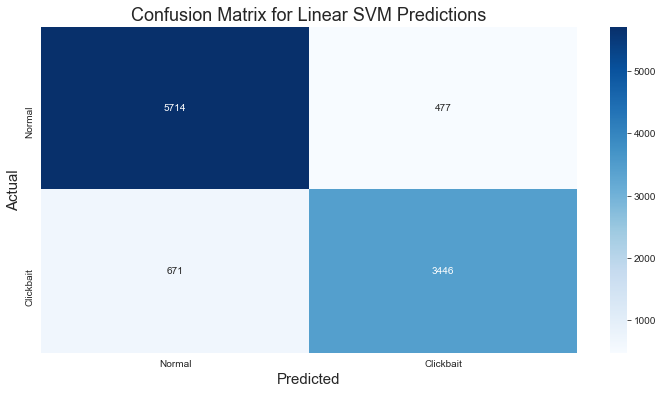

AUC: 0.9435482811027329


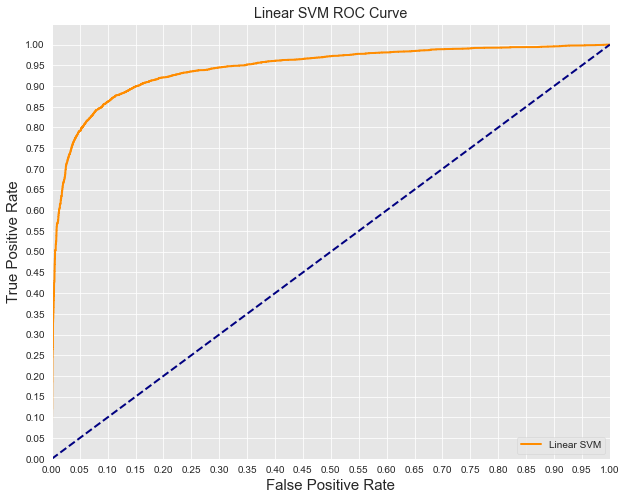

In [53]:
graph.plot_cmatrix(y_test,y_hat_svm_te, model = 'Linear SVM')
graph.plot_roc_curve(y_test, svm_clf.predict_proba(X_test_tfidf)[:,1], PATH="./src/images/SVMROC.png", model = 'Linear SVM')

This gave me a 1 point increase over the baseline. I will run a random forest model and see if I can improve but I think that I have reached a limit on what these models can achieve with this data. The reason for this is that the second data set that I have included in my analysis was flawed during the collection. I still think that the Bernoulli bayes and Logistic Regression are my best models so far.

In [54]:
# Pickle the model
filehandler = open("./src/models/model4.1.pickle", "wb")
pickle.dump(svm_clf, filehandler)
filehandler = open("./src/models/tfidf4.1.pickle", "wb")
pickle.dump(tfidf, filehandler)

## Random Forest

In [55]:
# Start off with the default paramaters
start_time = time.time()
forest_clf = RandomForestClassifier(oob_score=True, class_weight='balanced')

forest_clf.fit(X_train_tfidf, y_train)
y_hat_train_forest = forest_clf.predict(X_train_tfidf)
y_hat_test_forest = forest_clf.predict(X_test_tfidf)

print(f1_score(y_train, y_hat_train_forest), f1_score(y_test, y_hat_test_forest))
print("--- %s seconds ---" % (time.time() - start_time))

0.997567640611393 0.8405761418195248
--- 81.67303514480591 seconds ---


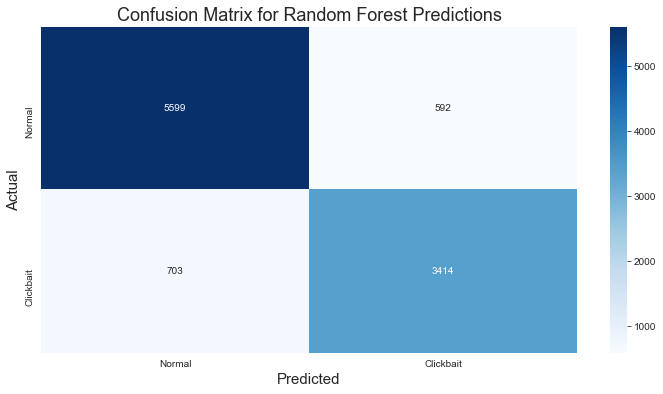

AUC: 0.9376917812677297


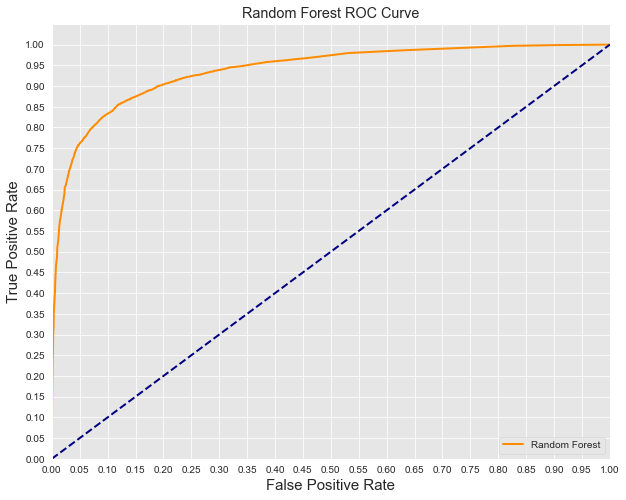

In [56]:
graph.plot_cmatrix(y_test, y_hat_test_forest, model="Random Forest")
graph.plot_roc_curve(y_test, forest_clf.predict_proba(X_test_tfidf)[:,1], PATH="./src/images/randomforest.png", model = 'Random Forest')

In [57]:
# Pickle the model
filehandler = open("./src/models/model5.1.pickle", "wb")
pickle.dump(forest_clf, filehandler)
filehandler = open("./src/models/tfidf5.1.pickle", "wb")
pickle.dump(tfidf, filehandler)

The more complicated models do not perform better than simple logistic regression or Naive bayes. For my case, I need the model run quickly and for them to be light weight, ie they can't be large files (So large that I am unable to push them to git hub). Since Random Forest and Linear SVM can be large on disk, I will opt for the naive bayes classifier.

However, as a Hail Mary, I will throw an XGboost algorithm in.  

# XGBoost

Use the same tfidf vectorizer from before, it has max features at 100000 So as to not overload the the model.

XGBoost is a very complicated ensemble method that bands together many weak models to make a prediciton. XGBoost has a lot of hyperperamters and the modification of most is well beyond my current knowledge. However, I used starter code taken from kaggle that allowed me to find the optimal configuration faster.

In [58]:
# Starter code adapted from https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
# convert sparse matrix to dmatrix 
dtrain = xgb.DMatrix(X_train_tfidf)
dterst = xgb.DMatrix(X_test_tfidf)

# Instantiate a param grid

params = {
        'min_child_weight': [2, 3, 5, 7],
        'gamma': [1, 1.2, 1.4,1.6],
        'subsample': [0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [1.0, 1.2],
        'max_depth': [20, 25, 27, 30, 35]
        }
xgb_clf = xgb.XGBClassifier(learning_rate=0.01, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 10
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(xgb_clf,
                                   param_distributions=params,
                                   n_iter=param_comb,
                                   scoring='roc_auc',
                                   n_jobs=-1,
                                   cv=skf.split(X_train_tfidf, y_train),
                                   verbose=3, random_state=42)

# Here we go
start_time = time.time()
random_search.fit(X_train_tfidf, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 50.6min finished


[14:35:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:35:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
--- 3542.919659137726 seconds ---


In [59]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All results:
{'mean_fit_time': array([5.43218659e+02, 2.44014955e-01, 4.65352150e+02, 5.02794641e+02,
       7.76975205e+02]), 'std_fit_time': array([4.69951124e+00, 8.92027973e-03, 5.77512379e+00, 4.39828437e+00,
       6.76203941e+01]), 'mean_score_time': array([0.53938143, 0.        , 0.49918544, 0.51770921, 0.64423997]), 'std_score_time': array([0.03544322, 0.        , 0.02224965, 0.01895843, 0.148449  ]), 'param_subsample': masked_array(data=[0.8, 1.0, 0.8, 0.8, 1.0],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[3, 2, 7, 5, 3],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[25, 27, 25, 25, 35],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[1.2, 1.2, 1.6, 1.2, 1],
             mask=[False, F

In [60]:
# Best normalized gini score for 10-fold search with 5 parameter combinations: 0.8252195510989879
first_model = {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 10, 'gamma': 1, 'colsample_bytree': 1.0}
# Best normalized gini score for 10-fold search with 5 parameter combinations: 0.8422927856989737
second_model = {'subsample': 0.8, 'min_child_weight': 3, 'max_depth': 15, 'gamma': 1.2, 'colsample_bytree': 1.0}
#  Best normalized gini score for 10-fold search with 5 parameter combinations: 0.8526724979493345 
third_model = {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 25, 'gamma': 1, 'colsample_bytree': 1.0}

0.8148053278688524


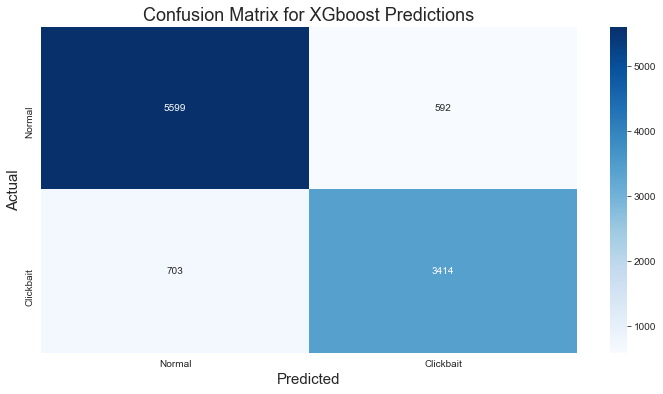

AUC: 0.924419755427843


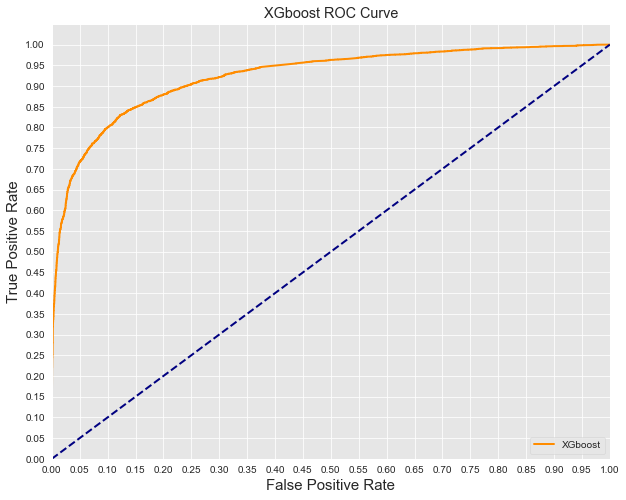

In [61]:
print(f1_score(y_test, random_search.best_estimator_.predict(X_test_tfidf)))
graph.plot_cmatrix(y_test, y_hat_test_forest, model="XGboost")
graph.plot_roc_curve(y_test,
                     random_search.best_estimator_.predict_proba(X_test_tfidf)[:,1],
                     PATH="./src/images/XGboost.png",
                     model = 'XGboost')

Write up the analysis of XGboost here.

In [62]:
# Save the model

# Pickle the model
filehandler = open("./src/models/model6.1.pickle", "wb")
pickle.dump(random_search.best_estimator_, filehandler)
filehandler = open("./src/models/tfidf6.1.pickle", "wb")
pickle.dump(tfidf, filehandler)

# Work in Progress.

The following section will outline and streamline the creation of the clickbait classfier. The preliminary live model can be found in `notebooks/EDA/scraper`. In it's current state, you can either type a sentence into it and it will return whether or not the sentence is clickbait or you can give it a url and it will return to you a dataframe of the headlines from the article and whether or not the headline is clickbait.



# ROC PROGRESS PLOT

First, I generate a prediction matrix which is X_test x number of models in shape. Once I have that matrix, I can run it through a custom roc-auc function I wrote that produces all of a graph with all of the 


In [45]:
# Load the models

# Best Model
filehandler = open("./src/models/model2.1.pickle", "rb")
multi_bayes = pickle.load(filehandler)

filehandler = open("./src/models/tfidf2.1.pickle", "rb")
multi_bayes_tfidf = pickle.load(filehandler)

# Logistic with cross validation 
filehandler = open("./src/models/model3.1.pickle", "rb")
log_CV = pickle.load(filehandler)

filehandler = open("./src/models/tfidf3.1.pickle", "rb")
log_CV_tfidf = pickle.load(filehandler)

# Linear SVM 
filehandler = open("./src/models/model4.1.pickle", "rb")
linear_SVM = pickle.load(filehandler)

filehandler = open("./src/models/tfidf4.1.pickle", "rb")
linear_SVM_tfidf = pickle.load(filehandler)

# Random Forest 
filehandler = open("./src/models/model5.1.pickle", "rb")
random_forest = pickle.load(filehandler)

filehandler = open("./src/models/tfidf5.1.pickle", "rb")
random_forest_tfidf = pickle.load(filehandler)

# XGboost 
filehandler = open("./src/models/model6.1.pickle", "rb")
XGboost = pickle.load(filehandler)

filehandler = open("./src/models/tfidf6.1.pickle", "rb")
XGboost_tfidf = pickle.load(filehandler)

# place models and tfidf in a list

model_list = [multi_bayes, log_CV, linear_SVM, random_forest, XGboost]
tfidif_list = [multi_bayes_tfidf, log_CV_tfidf, linear_SVM_tfidf, random_forest_tfidf, XGboost_tfidf]
model_names = ['Multinomial Naive Bayes', "Logistic Regression", "Linear SVM", "Random Forest", "XGBoost"]

In [46]:
full_matrix = graph.generate_prediction_matrix(model_list, tfidif_list, X_test);

Generating predictions for model: 1
[0.18334077 0.89443992 0.01463105 ... 0.24608038 0.05778237 0.01509   ]
Generating predictions for model: 2
[1.95833749e-02 9.94613888e-01 1.97930772e-03 ... 4.35043227e-03
 2.14689121e-03 1.72910980e-05]
Generating predictions for model: 3
[0.0269652  0.32030426 0.12646637 ... 0.19811678 0.11305192 0.00415236]
Generating predictions for model: 4
[0.16 0.4  0.02 ... 0.5  0.05 0.02]
Generating predictions for model: 5
[0.13286734 0.25773063 0.05342889 ... 0.40991154 0.12194931 0.02032651]


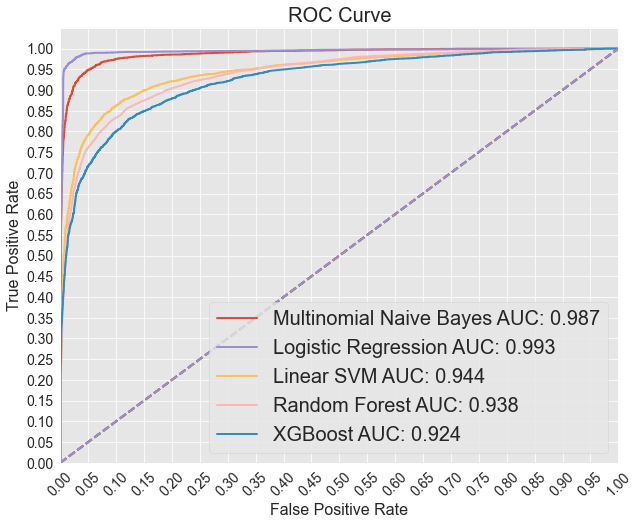

In [47]:
graph.plot_final_roc(full_matrix, model_names, y_test, PATH = "./src/images/final_roc.png")

I was initially surprised that random forest and XGboost performed poorly. However, when I thought throughthe nature of the model, I realized that these bagging and boosting algorithms will never perform as well on sparse data as something like naive bayes or logistic regression. When you bag a classifer with only a subset of the features in sparse data, you are increasing the chance of missing out on critical data. 


Logistic regression and Naive bayes on the other hand use all of the data available to it, and factor in the missing data as a feature in and of itself. Therefore, it is not surprising to me that multinomial bayes and logisitc regression ended up being my strongest models.

# HTML PARSER

This is a the start of the parser. Currently, it takes in as it's input a url and returns to the user a list of cleaned headlines with their predictions. 

In [48]:
# import chakraborty only model 

fp = open("./src/models/model1.1.pickle", 'rb')
model = pickle.load(fp)
fp = open("./src/models/tfidf1.1.pickle", 'rb')
tfidf = pickle.load(fp)

In [49]:
from bs4 import BeautifulSoup
import requests 

def get_headlines(response_text, tags=['h1', 'h2', 'h3', 'h4']):
    soup = BeautifulSoup(response_text, 'lxml')
    headers = soup.find_all(tags)
    return [header.text for header in headers]

def clean_headlines(title, length, stopwords = False):
    title = title.replace("\n", "")
    title = title.replace("\t", "")
    title = pp.remove_non_ascii_chars(title)
    title = pp.lower_case(title)
    title = pp.remove_contractions(title)
    title = pp.lemmetise_series(title)
    title = "".join([char for char in title if char not in string.punctuation])
    # remove stopwords
#     if stopwords:
    title = " ".join([char for char in tokenizer.tokenize(title) if char not in pp.stop_words ])
    if len(title.split()) < length:
         return None

    return title
    
def get_cleaned_headlines(url, length=4, tags=['h1', 'h2', 'h3']):
    text = requests.get(url).text
    return pd.Series([clean_headlines(headline, length) for headline in get_headlines(text, tags=tags)] , name='title')



In [50]:
def get_html_series(url):
    cleaned_headlines = get_cleaned_headlines(url)
    series = cleaned_headlines.dropna()
    
    return series

def predict_on_html(series, model, tfidf):
    series_tfidf = tfidf.transform(series)
    predictions = model.predict(series_tfidf)
    target = pd.Series(predictions, name='target')

    df = pd.DataFrame(list((zip(series, target))), columns=['title', 'target'])
    
    return df

def domain_name(url):
    """
    Takes in a string an returns the url domain name
    
    Limited use case.
    
    Wrote this as part of a codewars code challange. Happy it came in handy.
    
    """
    return url.split("//")[-1].split("www.")[-1].split(".")[0]

Now that we have defined a set of functions that can read in headings from html and then make predictions on them, we can move forward and have a look at which websites produce the most clickbaity headlines

In [51]:
upworthy = 'https://www.UpWorthy.com/'
buzzfeed = "https://www.Buzzfeed.com"
NYT = "https://www.NYtimes.com"
WP = "https://www.WashingtonPost.com"
NYP = "https://NYPost.com"
NPR = "https://www.NPR.org"
huffpost = "https://www.Huffpost.com"

In [52]:
NYT_df = predict_on_html(get_html_series(NYT), model, tfidf)
WP_df = predict_on_html(get_html_series(WP), model, tfidf)
upworthy_df = predict_on_html(get_html_series(upworthy), model, tfidf)
buzzfeed_df = predict_on_html(get_html_series(buzzfeed), model, tfidf)
NYP_df = predict_on_html(get_html_series(NYP), model, tfidf)
NPR_df = predict_on_html(get_html_series(NPR), model, tfidf)
# huffpost_df = predict_on_html(get_html_series(huffpost), model, tfidf)

''

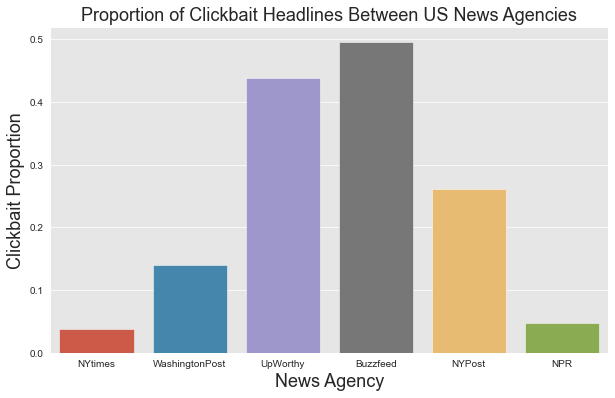

In [53]:

df_list = [NYT_df, WP_df, upworthy_df, buzzfeed_df, NYP_df, NPR_df]
url_list = [NYT, WP, upworthy, buzzfeed, NYP, NPR]

mean_clickbait_probability = [model.target.mean() for model in df_list]
domain_names = [domain_name(url) for url in url_list]

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x= domain_names, y=mean_clickbait_probability, ax=ax)
plt.title("Proportion of Clickbait Headlines Between US News Agencies", size = 18)
plt.ylabel("Clickbait Proportion", size = 18)
plt.xlabel("News Agency", size = 18)
plt.savefig("./src/images/urlpredictions.png", bbox_inches='tight', transparent=True)
;

When the API is used to classify a handful of popular media websites, the results align with what one might expect based on a common knowledge of the types of content these websites produce.

# Thoughts and Conclusions

Given what I know about the industry, this model seems accurate. Buzzfeed and upworthy are notorious clickbait websites whereas the NYT, Washington Post and NPR are not. I included the nypost as that is considered somewhere in between and indeed, it sits somewhere in between the other posts. 

The reasons for the impressive performance is likely due to the method the labellers did in the Chakraborty database. Clickbait is a subjective classification. Therefore great care needs to be taken in how it is defined between labellers. It is evident that simply hiring amazon mechanical turks is insufficient to properly classify the data.

A potential weakness of the  model is that websites who do not use html header tags (h1-h4) to label their headlines will be missed by my html parser. However, that is a minor issue that there are likely many good python libraries that I could use to solve. In addition, the model is likely too sensitive to be used in production to actually clean the headlines from the html. Even at 95% accuracy, 1/20 headlines is too many misclassifications. We see potentially hundreds of headlines a day and that would get on the user's nerve. On the other hand, if i were to simply parse the entire html and deliver the proportion of headlines, the accuracy would be masked in the aggregate. 

From here, I will create a flask application with a specific api endpoint. Using that endpoint, I will set up a chrome extension that will make calls to my API in order to read URLS and warn the user of the clickbait contained within the website.



Thank you for reading! 



# Example of a API call:

In [72]:
import requests

In [73]:
url = 'https://baitnswitch.herokuapp.com/apiendpoint'
myobj = {'headline': "The Health 202: When will 2021 feel normal again? Here's what eight experts predict."}

x = requests.post(url, data = myobj)

print(x.text)

[0.9966131]
